In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [2]:
odr=pd.read_csv('orders_cleaned.csv', parse_dates=['order_datetime'])
rt_rf=pd.read_csv('returns_refund_cleaned.csv')

In [3]:
conn=sqlite3.connect(':memory:')

In [4]:
odr.to_sql('orders',conn,index=False,if_exists='replace')
rt_rf.to_sql('returns_refund',conn,index=False,if_exists='replace')

2000

Performed a left join between orders and returns_refund on or_id. Since returns_refund only has returned/refunded orders, unmatched rows indicate delivered orders. Using a CASE statement, we label 'return' and 'refund' as 'returned', and NULL as 'delivered'.

In [6]:
query="""
            select odr.or_id,
            case 
                when lower(rt_rf.status) = 'refund' then 'returned'
                when lower(rt_rf.status) = 'return' then 'returned'
                when rt_rf.status IS NULL THEN 'delivered'
                else rt_rf.status
            end as status
            from orders odr
            left join returns_refund rt_rf on odr.or_id = rt_rf.or_id
"""


In [7]:
df=pd.read_sql_query(query,conn)
print(df)

             or_id     status
0      or_31000001   returned
1      or_31000002  delivered
2      or_31000003  delivered
3      or_31000004   returned
4      or_31000005  delivered
...            ...        ...
10175  or_31009996  delivered
10176  or_31009997  delivered
10177  or_31009998  delivered
10178  or_31009999  delivered
10179  or_31010000  delivered

[10180 rows x 2 columns]


In [8]:
df.to_csv('return_status.csv',index=False)

Merging for Prediction

In [10]:
cu=pd.read_csv('customers_cleaned.csv')
odr=pd.read_csv('orders_cleaned.csv', parse_dates=['order_datetime'])
prd=pd.read_csv('products_cleaned.csv')
dv=pd.read_csv('delievry_cleaned.csv')
rt=pd.read_csv('ratings_cleaned.csv')
tra=pd.read_csv('transactions_cleaned.csv')
sup=pd.read_csv('supplires_cleaned.csv')
rs=pd.read_csv('return_status.csv')

In [11]:
cu.to_sql('customers',conn,index=False,if_exists='replace')
odr.to_sql('orders',conn,index=False,if_exists='replace')
prd.to_sql('products',conn,index=False,if_exists='replace')
dv.to_sql('delievry',conn,index=False,if_exists='replace')
rt.to_sql('ratings',conn,index=False,if_exists='replace')
tra.to_sql('transactions',conn,index=False,if_exists='replace')
sup.to_sql('supplires',conn,index=False,if_exists='replace')
rs.to_sql('return_status',conn,index=False,if_exists='replace')


10180

In [12]:
query = """
            select  odr.or_id,odr.order_datetime,odr.qty,
                    cu.c_id,cu.gender,cu.state,cu.city,cu.age,
                    prd.p_id,prd.category,prd.price,
                    rs.status,
                    dv.dp_id,dv.dp_ratings,
                    rt.r_id,rt.prod_rating,rt.delivery_service_rating,
                    sup.sup_id,sup.sup_name,
                    tra.transaction_mode,tran_status
            from orders odr
            left join customers cu on cu.c_id = odr.c_id
            left join products prd on odr.p_id = prd.p_id
            left join return_status rs on rs.or_id = odr.or_id
            left join delievry dv on dv.dp_id = odr.dp_id
            left join ratings rt on rt.or_id = odr.or_id
            left join supplires sup on sup.sup_id = prd.sup_id
            left join transactions tra on tra.or_id = odr.or_id
"""

In [13]:
df=pd.read_sql_query(query,conn)
print(df)

             or_id       order_datetime  qty         c_id  gender  \
0      or_31000001  2024-02-27 22:02:00    1  cs_11005317    male   
1      or_31000002  2024-01-21 08:33:31    5  cs_11000423  female   
2      or_31000002  2024-01-21 08:33:31    5  cs_11000423  female   
3      or_31000003  2024-09-22 17:26:05    1  cs_11001042    male   
4      or_31000004  2023-05-26 03:15:48   10  cs_11004079  female   
...            ...                  ...  ...          ...     ...   
19162  or_31009998  2024-12-28 17:50:17    6  cs_11003081    male   
19163  or_31009999  2024-07-15 20:24:29    6  cs_11006873  female   
19164  or_31010000  2023-11-01 23:07:12    6  cs_11001833    male   
19165  or_31010000  2023-11-01 23:07:12    6  cs_11001833    male   
19166  or_31010000  2023-11-01 23:07:12    6  cs_11001833    male   

               state       city  age         p_id        category  ...  \
0        maharashtra     mumbai   67  pd_21001301         fitness  ...   
1          karnataka  b

In [14]:
df.isnull().sum()

or_id                         0
order_datetime                0
qty                           0
c_id                          0
gender                        0
state                         0
city                          0
age                           0
p_id                          0
category                      0
price                         0
status                        0
dp_id                         0
dp_ratings                    0
r_id                       5175
prod_rating                5175
delivery_service_rating    5175
sup_id                        0
sup_name                      0
transaction_mode           5348
tran_status                5305
dtype: int64

In [15]:
df.fillna(0,inplace=True)

In [16]:
df.isnull().sum()

or_id                      0
order_datetime             0
qty                        0
c_id                       0
gender                     0
state                      0
city                       0
age                        0
p_id                       0
category                   0
price                      0
status                     0
dp_id                      0
dp_ratings                 0
r_id                       0
prod_rating                0
delivery_service_rating    0
sup_id                     0
sup_name                   0
transaction_mode           0
tran_status                0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19167 entries, 0 to 19166
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   or_id                    19167 non-null  object 
 1   order_datetime           19167 non-null  object 
 2   qty                      19167 non-null  int64  
 3   c_id                     19167 non-null  object 
 4   gender                   19167 non-null  object 
 5   state                    19167 non-null  object 
 6   city                     19167 non-null  object 
 7   age                      19167 non-null  int64  
 8   p_id                     19167 non-null  object 
 9   category                 19167 non-null  object 
 10  price                    19167 non-null  float64
 11  status                   19167 non-null  object 
 12  dp_id                    19167 non-null  object 
 13  dp_ratings               19167 non-null  float64
 14  r_id                  

In [18]:
print(df)
df.to_csv('merged_for_prediction.csv',index=False)

             or_id       order_datetime  qty         c_id  gender  \
0      or_31000001  2024-02-27 22:02:00    1  cs_11005317    male   
1      or_31000002  2024-01-21 08:33:31    5  cs_11000423  female   
2      or_31000002  2024-01-21 08:33:31    5  cs_11000423  female   
3      or_31000003  2024-09-22 17:26:05    1  cs_11001042    male   
4      or_31000004  2023-05-26 03:15:48   10  cs_11004079  female   
...            ...                  ...  ...          ...     ...   
19162  or_31009998  2024-12-28 17:50:17    6  cs_11003081    male   
19163  or_31009999  2024-07-15 20:24:29    6  cs_11006873  female   
19164  or_31010000  2023-11-01 23:07:12    6  cs_11001833    male   
19165  or_31010000  2023-11-01 23:07:12    6  cs_11001833    male   
19166  or_31010000  2023-11-01 23:07:12    6  cs_11001833    male   

               state       city  age         p_id        category  ...  \
0        maharashtra     mumbai   67  pd_21001301         fitness  ...   
1          karnataka  b

In [19]:
df = pd.read_csv("merged_for_prediction.csv")
print(df.columns.tolist())
df.head()

['or_id', 'order_datetime', 'qty', 'c_id', 'gender', 'state', 'city', 'age', 'p_id', 'category', 'price', 'status', 'dp_id', 'dp_ratings', 'r_id', 'prod_rating', 'delivery_service_rating', 'sup_id', 'sup_name', 'transaction_mode', 'tran_status']


,or_id,order_datetime,qty,c_id,gender,state,city,age,p_id,category,...,status,dp_id,dp_ratings,r_id,prod_rating,delivery_service_rating,sup_id,sup_name,transaction_mode,tran_status
0,or_31000001,2024-02-27 22:02:00,1,cs_11005317,male,maharashtra,mumbai,67,pd_21001301,fitness,...,returned,dv_61000087,3.2,rt_101006049,1.0,3.0,sup_026,ecomgenix suppliers,upi,successful
1,or_31000002,2024-01-21 08:33:31,5,cs_11000423,female,karnataka,bengaluru,59,pd_21003593,fashion,...,delivered,dv_61000085,3.6,rt_101003663,2.0,4.0,sup_024,trendmart inc.,0,0
2,or_31000002,2024-01-21 08:33:31,5,cs_11000423,female,karnataka,bengaluru,59,pd_21003593,fashion,...,delivered,dv_61000085,3.6,rt_101009487,5.0,5.0,sup_024,trendmart inc.,0,0
3,or_31000003,2024-09-22 17:26:05,1,cs_11001042,male,delhi,delhi,44,pd_21004315,books,...,delivered,dv_61000237,3.7,0,0.0,0.0,sup_025,quickbasket co.,0,0
4,or_31000004,2023-05-26 03:15:48,10,cs_11004079,female,uttar pradesh,ghaziabad,57,pd_21007443,home appliance,...,returned,dv_61000292,3.5,rt_101002512,1.0,4.0,sup_006,quickpick wholesalers,debit card,failed


In [20]:
# Load data
df = pd.read_csv('merged_for_prediction.csv')

df['tran_status'] = df['tran_status'].str.lower()

# Filter out failed transactions
df = df[df['tran_status'] != 'failed']
df = df[df['tran_status'] != '0']

# --- Fix status column ---
df = df[df['status'].notna()]  # Drop rows with NaN status
df['status'] = df['status'].str.lower().replace({'deliveried': 'delivered'})  # Fix typo
df['target'] = df['status'].map({'returned': 1, 'delivered': 0})


# Drop if target is still NaN
df = df[df['target'].isin([0, 1])]

# --- Drop unused or ID columns ---
id_cols = [col for col in df.columns if col.endswith('_id') or col in ['mobile',  'c_id', 'c_name']]
df.drop(columns=id_cols, inplace=True, errors='ignore')

# --- Drop the original status column ---
df.drop(columns=['status'], inplace=True)

# --- Drop columns with >30% missing ---
df.dropna(thresh=len(df) * 0.7, axis=1, inplace=True)

# --- Separate features and target ---
X = df.drop(columns=['target'])
y = df['target']

# --- Encode categorical features ---
X = pd.get_dummies(X, drop_first=True)

# --- Fill remaining missing values ---
X = X.fillna(X.median(numeric_only=True))

# --- Scale numeric features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# --- Train logistic regression model ---
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# --- Evaluate ---
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      1092
           1       1.00      0.65      0.79       287

    accuracy                           0.93      1379
   macro avg       0.96      0.82      0.87      1379
weighted avg       0.93      0.93      0.92      1379

Confusion Matrix:
 [[1092    0]
 [ 101  186]]
ROC AUC Score: 0.9277737361361054


In [21]:
# Generate return probabilities
df["return_probability"] = model.predict_proba(X)[:, 1]

# Save for Power BI dashboard
df.to_csv("orders_with_return_risk.csv", index=False)
print("✅ Return probabilities saved to orders_with_return_risk.csv")


C:\Users\REDDY\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


✅ Return probabilities saved to orders_with_return_risk.csv


In [22]:
df.head()

,order_datetime,qty,gender,state,city,age,category,price,dp_ratings,prod_rating,delivery_service_rating,sup_name,transaction_mode,tran_status,target,return_probability
0,2024-02-27 22:02:00,1,male,maharashtra,mumbai,67,fitness,330.13,3.2,1.0,3.0,ecomgenix suppliers,upi,successful,1,0.198116
6,2023-10-26 04:02:44,7,male,andhra pradesh,visakhapatnam,28,electronics,124.24,3.5,5.0,4.0,nextwave merchants,wallet,successful,0,0.017663
7,2023-10-26 04:02:44,7,male,andhra pradesh,visakhapatnam,28,electronics,124.24,3.5,5.0,1.0,nextwave merchants,wallet,successful,0,0.015831
8,2023-10-26 04:02:44,7,male,andhra pradesh,visakhapatnam,28,electronics,124.24,3.5,2.0,5.0,nextwave merchants,wallet,successful,0,0.018156
11,2023-05-18 23:41:25,9,female,maharashtra,thane,32,fitness,67.51,4.6,0.0,0.0,pack&go logistics,credit card,successful,0,0.007205


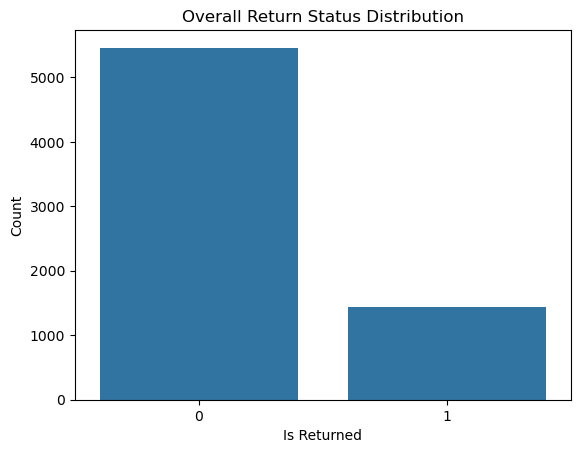

In [23]:
# Distribution of the target variable
sns.countplot(x='target', data=df)
plt.title('Overall Return Status Distribution')
plt.xlabel('Is Returned')
plt.ylabel('Count')
plt.show()

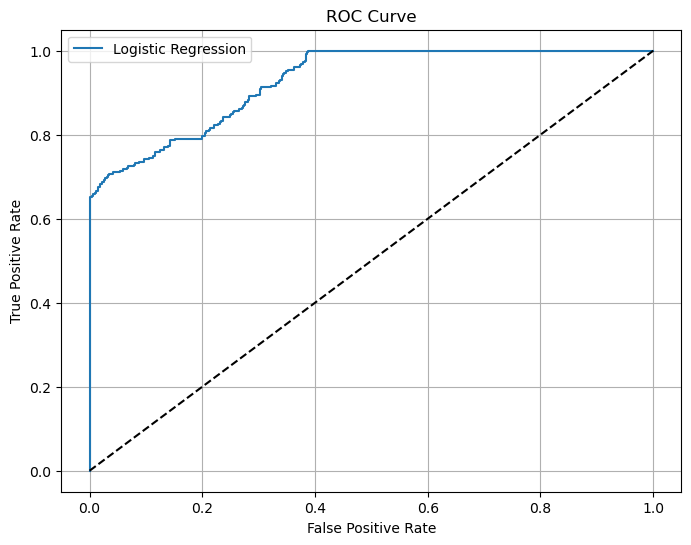

In [24]:
# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
df = pd.read_csv("orders_with_return_risk.csv")

# Filter high-risk orders (return_risk_score > 0.6)
high_risk_df = df[df['return_probability'] > 0.6]

# Optional: Sort by highest risk
high_risk_df = high_risk_df.sort_values(by='return_probability', ascending=False)

# Export to CSV
high_risk_df.to_csv("high_risk_products.csv", index=False)

print(f"✅ Exported {len(high_risk_df)} high-risk products to 'high_risk_products.csv'")


✅ Exported 991 high-risk products to 'high_risk_products.csv'


In [26]:
high_risk_df.head()

,order_datetime,qty,gender,state,city,age,category,price,dp_ratings,prod_rating,delivery_service_rating,sup_name,transaction_mode,tran_status,target,return_probability
1612,2024-10-27 07:22:31,2,female,madhya pradesh,indore,18,fitness,495.09,0.0,5.0,4.0,elite ecom ventures,debit card,successful,0,0.951307
1613,2024-10-27 07:22:31,2,female,madhya pradesh,indore,18,fitness,495.09,0.0,2.0,4.0,elite ecom ventures,debit card,successful,0,0.950884
1723,2024-02-07 07:26:58,3,female,delhi,delhi,23,fitness,488.42,3.7,1.0,4.0,trendify traders,upi,successful,1,0.944502
1724,2024-02-07 07:26:58,3,female,delhi,delhi,23,fitness,488.42,3.7,1.0,4.0,trendify traders,wallet,successful,1,0.944227
1722,2024-02-07 07:26:58,3,female,delhi,delhi,23,fitness,488.42,3.7,1.0,4.0,trendify traders,net banking,successful,1,0.941700
